In [10]:
import os
import numpy as np
import cv2
import torch
import torchvision.transforms as tf
from course_ocr_t1.data import MidvPackage
from pathlib import Path
from torch.nn import functional as F

Learning_Rate = 1e-5
width = 256,
height = 128
batchSize = 16

In [8]:
DATASET_PATH = Path() / '..' / '..'/ '..' / 'data' / 'midv500_compressed'
assert DATASET_PATH.exists(), DATASET_PATH.absolute()
# Собираем список пакетов (MidvPackage) 
data_packs = MidvPackage.read_midv500_dataset(DATASET_PATH)
len(data_packs), type(data_packs[0])

(50, course_ocr_t1.data.MidvPackage)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
train_split = []
test_split = []

for dp in data_packs:
    for i in range(len(dp)):
        if dp[i].is_test_split():
            test_split.append(dp[i])
        else:
            train_split.append(dp[i])

In [17]:
import segmentation_models_pytorch

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

transformImg=tf.Compose([tf.Resize((height,width)),tf.ToTensor(),tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

def ReadRandomImage(list_images):
    cur_index = np.random.randint(0,len(list_images))
    cur_image = list_images[cur_index].image
    
    polygon = [(x, y) for x, y in list_images[cur_index].gt_data['quad']]
    mask = Image.new('L', (cur_image.size[0], cur_image.size[1]), 0)
    ImageDraw.Draw(mask).polygon(polygon, outline=0, fill=1)
    mask = np.array(mask)
    
    cur_image = transformImg(cur_image)
    mask = cv2.resize(mask, (cur_image.shape[2], cur_image.shape[1]))

    return cur_image, torch.Tensor([mask])


def LoadBatch(list_images):
    images = torch.zeros([batchSize, 3, height, width])
    ann = torch.zeros([batchSize, height, width])
    for i in range(batchSize):
        images[i],ann[i]=ReadRandomImage(list_images)
    return images, ann

In [ ]:
Net = segmentation_models_pytorch.UnetPlusPlus(in_channels=3, classes=1)
Net=Net.to(device)
optimizer=torch.optim.Adam(params=Net.parameters(),lr=Learning_Rate)

mode = 'binary'
loss = segmentation_models_pytorch.losses.LovaszLoss(mode)

m = torch.nn.Sigmoid()

saving model iter: 0
0  loss:  1.6087


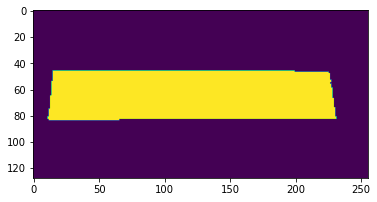

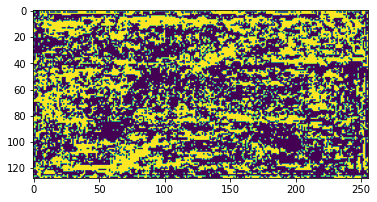

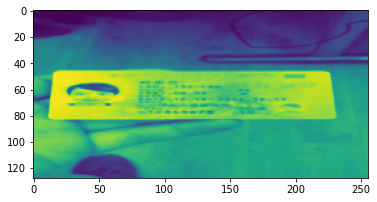

saving model iter: 100
100  loss:  0.7558916


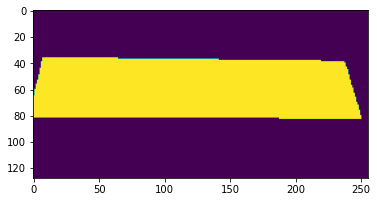

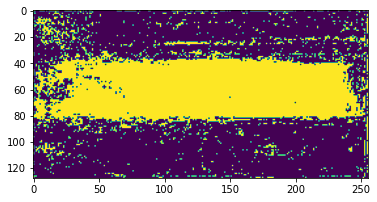

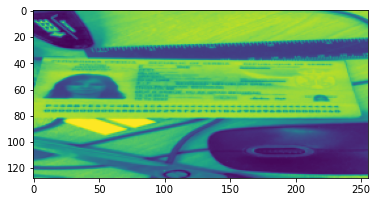

saving model iter: 200
200  loss:  0.52316296


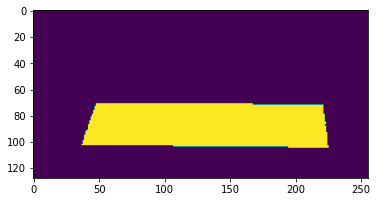

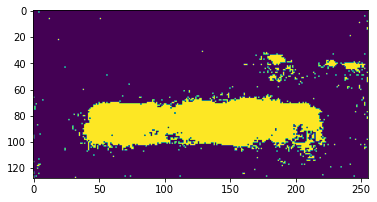

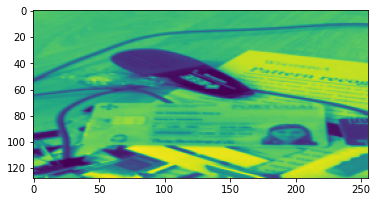

saving model iter: 300
300  loss:  0.3379627


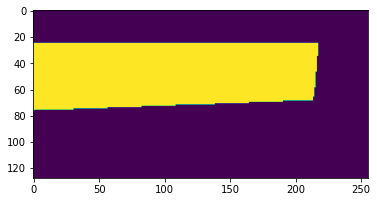

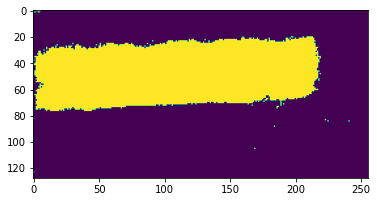

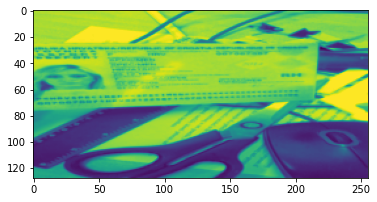

saving model iter: 400
400  loss:  0.20295131


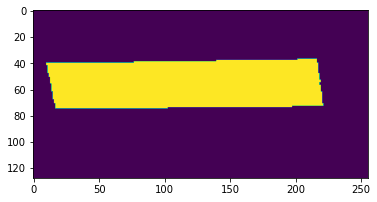

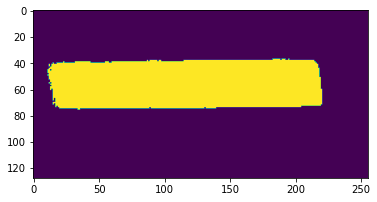

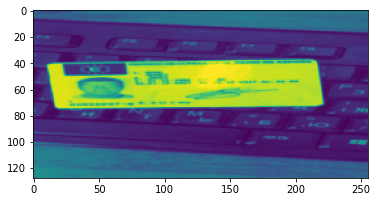

saving model iter: 500
500  loss:  0.15465984


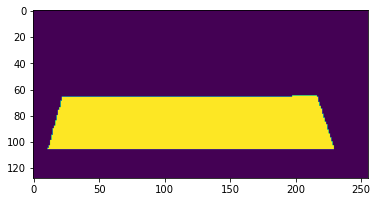

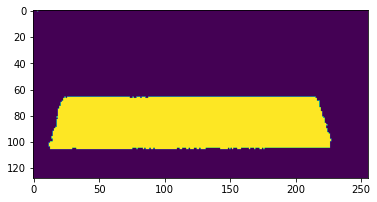

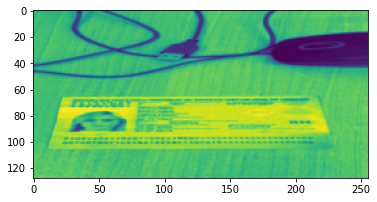

KeyboardInterrupt: 

In [18]:
for itr in range(1000):
    images,ann=LoadBatch(train_split)
    images = images.to(device)

    ann = torch.autograd.Variable(ann, requires_grad=False).to(device)
    Pred = Net(images)
    Net.zero_grad()

    cur_loss = loss(Pred, ann.long())

    cur_loss.backward()
    optimizer.step()
    seg = torch.argmax(Pred[0], 0).cpu().detach().numpy()
    
    
    if itr % 100 == 0:
        print("saving model iter: {}".format(itr))
        torch.save(Net.state_dict(),   "unet_plus_plus_{}.torch".format(itr))
        
        print(itr," loss: ",Loss.data.cpu().numpy())
        plt.imshow(ann.detach().cpu().numpy()[0])
        plt.show()
        plt.imshow(m(Pred).detach().cpu().numpy()[0][0] > 0.5)
        plt.show()
        
        plt.imshow(images.detach().cpu().numpy()[0][0])
        plt.show()
        